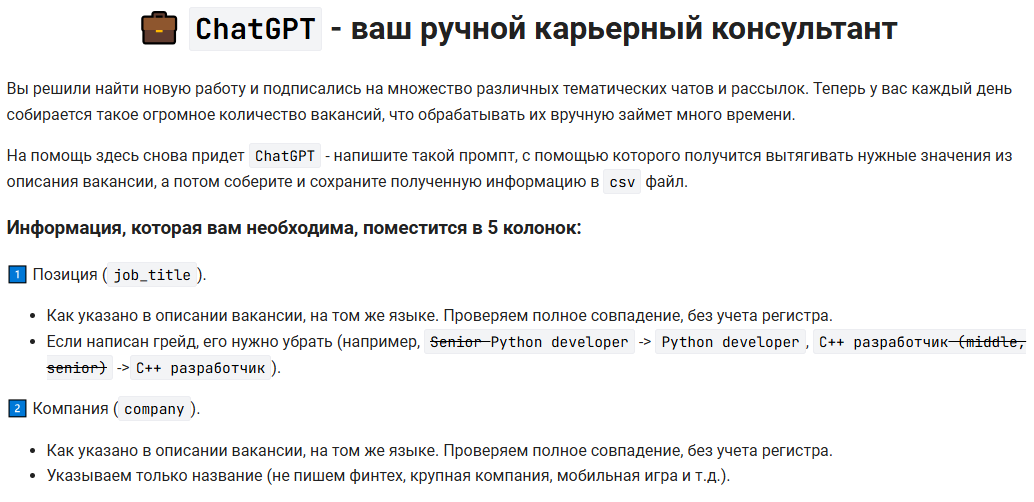

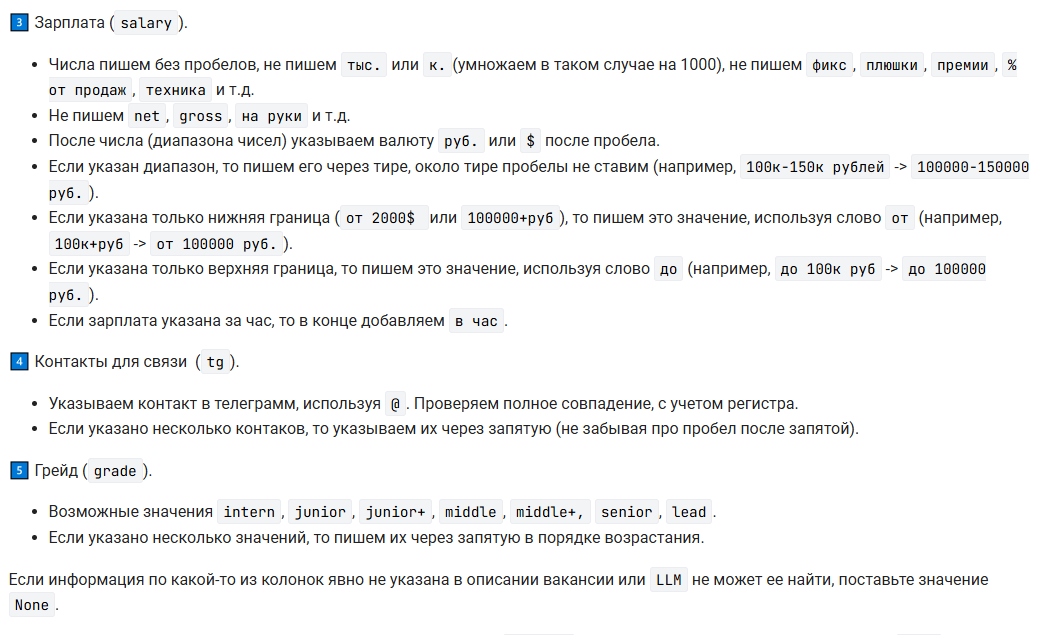

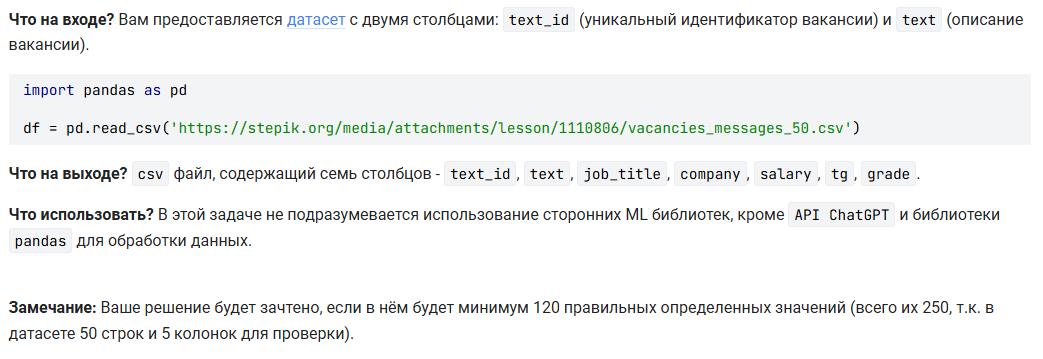

In [1]:
from langchain_openai import ChatOpenAI
from getpass import getpass
import pandas as pd
from tqdm import tqdm

#course_api_key= "Введите ваш API ключ с курса"
course_api_key = getpass(prompt='Введите API ключ')

# Инициализируем языковую модель
llm = ChatOpenAI(api_key=course_api_key, model='gpt-4o-mini',
                 base_url="https://aleron-llm.neuraldeep.tech/")

In [2]:
df = pd.read_csv("vacancies_messages_50.csv",encoding='utf-8')
df.head()

,text_id,text
0,9,#вакансия #vacancy #Python #удаленка #flask #r...
1,31,#ВАКАНСИЯ #Системный_аналитик #РФ\n \nАКЦИОНЕ...
2,28,#вакансия #vacancy #job #senior #data #DB #dat...
3,49,#вакансия #fulltime #remote \n\n🔎 Ищем Руковод...
4,18,#vacancy #job #analyst #travel #sirenatravel #...


In [5]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

job_title_schema = ResponseSchema(
    name='job_title'
    ,description="""Напиши название позиции как указано в описании вакансии, на том же языке. Проверяй полное совпадение, без учета регистра
    Если написан грейд, его нужно убрать (например, Senior Python developer -> Python developer, C++ разработчик (middle, senior) -> C++ разработчик)"""
)

company_schema = ResponseSchema(
    name='company'
    ,description="""Напиши название компании как указано в описании , на том же языке. Проверяй полное совпадение, без учета регистра
    Указываем только название - не пишем финтех, крупная компания, мобильная игра и так далее"""
)

salary_schema = ResponseSchema(
    name='salary'
    ,description="""Необходимо написать зарплату:
    1. Числа пишем без пробелов, не пишем тыс. или к.(умножаем в таком случае на 1000), не пишем фикс, плюшки, премии, % от продаж, техника и так далее
    2. Не пишем net, gross, на руки и так далее
    3. После числа (диапазона чисел) указываем валюту руб. или $ после пробела.
    4. Если указан диапазон, то пишем его через тире, около тире пробелы не ставим (например, 100к-150к рублей -> 100000-150000 руб.).
    5. Если указана только нижняя граница (от 2000$ или 100000+руб), то пишем это значение, используя слово от (например, 100к+руб -> от 100000 руб.).
    6. Если указана только верхняя граница, то пишем это значение, используя слово до (например, до 100к руб -> до 100000 руб.).
    7. Если зарплата указана за час, то в конце добавляем в час."""
)

tg_schema = ResponseSchema(
    name='tg'
    ,description="""Необходимо указать контакт в телеграмм, используя @. Проверяем полное совпадение, с учетом регистра.
    Если указано несколько контаков, то указываем их через запятую (не забывая про пробел после запятой)"""
)

grade_schema = ResponseSchema(
    name='grade'
    ,description="""Возможные значения intern, junior, junior+, middle, middle+, senior, lead.
    Если указано несколько значений, то пишем их через запятую в порядке возрастания."""
)

#Список схем
response_schemas = [job_title_schema, 
                    company_schema,
                    salary_schema,
                    tg_schema,
                    grade_schema]

In [65]:
#Создаем парсер
output_parser = StructuredOutputParser.from_response_schemas(response_schemas)

#Получаем инструкции по форматированию ответа
format_instructions = output_parser.get_format_instructions()


#Создаем шаблон
review_template = """\
Из следующего текста извлеки информацию:

job_title: Напиши название позиции как указано в описании вакансии, на том же языке. Проверяй полное совпадение, без учета регистра
Если написан грейд, его нужно убрать (например, Senior Python developer -> Python developer, C++ разработчик (middle, senior) -> C++ разработчик)


company: Сколько дней потребовалось для доставки товара? 
Напиши название компании как указано в описании , на том же языке. Проверяй полное совпадение, без учета регистра
Указываем только название - не пишем финтех, крупная компания, мобильная игра и так далее

salary: Необходимо написать зарплату:
    1. Числа пишем без пробелов, не пишем тыс. или к.(умножаем в таком случае на 1000), не пишем фикс, плюшки, премии, % от продаж, техника и так далее
    2. Не пишем net, gross, на руки и так далее
    3. После числа (диапазона чисел) указываем валюту руб. или $ после пробела.
    4. Если указан диапазон, то пишем его через тире, около тире пробелы не ставим (например, 100к-150к рублей -> 100000-150000 руб.).
    5. Если указана только нижняя граница (от 2000$ или 100000+руб), то пишем это значение, используя слово от (например, 100к+руб -> от 100000 руб.).
    6. Если указана только верхняя граница, то пишем это значение, используя слово до (например, до 100к руб -> до 100000 руб.).
    7. Если зарплата указана за час, то в конце добавляем в час.

tg: Необходимо указать контакт в телеграмм, используя @. Проверяем полное совпадение, с учетом регистра.
Если указано несколько контаков, то указываем их через запятую (не забывая про пробел после запятой)

grade: Возможные значения intern, junior, junior+, middle, middle+, senior, lead.
Если указано несколько значений, то пишем их через запятую в порядке возрастания.



Если информация по какой-то из колонок явно не указана в описании вакансии или не можешь найти, поставь значение "None" - в кавычках

text: {text}

{format_instructions}

"""

In [66]:
from langchain.prompts import ChatPromptTemplate

columns=['job_title','company','salary','tg','grade']
output_df = pd.DataFrame(columns=columns)
counter = 0
prompt = ChatPromptTemplate.from_template(template=review_template)

for text_input in tqdm(df['text']):
    messages = prompt.format_messages(text=text_input
                                  ,format_instructions=format_instructions)

    response = llm.invoke(messages)
    try:
        output_dict = output_parser.parse(response.content)
    except:
        print(response.content)
        break
    row = pd.DataFrame(output_dict,index=[counter])
    output_df = pd.concat([output_df,row],axis=0,sort=False)

100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


In [77]:
# output_df.to_csv("vacancies_messages_res.csv",sep=';',encoding='utf-8')
res = output_df.drop(labels=['level_0','index'],axis=1)
# res.to_csv('2_2_8_solution.csv',index=False)
res

,job_title,company,salary,tg,grade
0,Python developer,Collectly,6000-9000 $,@ann_gfio,None
1,Системный аналитик,АКЦИОНЕРНОЕ ОБЩЕСТВО «ГЛАВНЫЙ НАУЧНЫЙ ИННОВАЦИ...,320000-370000 руб.,@NatalyaMaki,None
2,Database Administrator,Match Systems,от 3000 $,@lex_kertis,senior
3,Руководитель отдела системного администрирования,None,от 3000 $,@ResearcherRIT,None
4,Analyst,Sirena Travel,120000-180000 руб.,@ann_gfio,None
5,DevOps инженер,Mad Devs,до 5000 $,@recruiter_maddevs,senior
6,Системный аналитик,Платформа,180000-300000 руб.,@Alexandrabogdanova_96,"senior,middle+,lead"
7,Python/Django full-stack разработчика,ivelum,4000-6000 $,@lebedevaoi,None
8,Go разработчик,КА Алешин Д.А.,до 500000 руб.,@AleshinDmitry80,middle
9,Разработчик (Vue.js / Golang),None,None,None,junior


In [78]:
df

,text_id,text
0,9,#вакансия #vacancy #Python #удаленка #flask #r...
1,31,#ВАКАНСИЯ #Системный_аналитик #РФ\n \nАКЦИОНЕ...
2,28,#вакансия #vacancy #job #senior #data #DB #dat...
3,49,#вакансия #fulltime #remote \n\n🔎 Ищем Руковод...
4,18,#vacancy #job #analyst #travel #sirenatravel #...
5,48,#вакансия #fulltime #remote #lookfor #devops\n...
6,41,#вакансия #senior #middle+ #lead #удаленка #оф...
7,6,#job #python #django #javascript #react #fulls...
8,17,#вакансия #vacancy #middle #senior #remote #уд...
9,4,Вакансия: Разработчик (Vue.js / Golang) для на...


In [84]:
from langchain.agents import load_tools
from langchain_core.tools import StructuredTool

tools = load_tools(["arxiv", "wikipedia"], llm=llm)

def summ(a:int, b:int) -> int:
    return a + b

summ_tool = StructuredTool(
    name='Summator',
    func=summ,
    description='Складывает 2 числа'
)

tools.append(summ_tool)

ImportError: Could not import arxiv python package. Please install it with `pip install arxiv`.